# Feature Extraction with Data Augmentation

### Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.utils import np_utils
from keras.callbacks import Callback
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from tensorflow.python.keras.callbacks import TensorBoard

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

from time import time
import os
import wandb
from wandb.keras import WandbCallback
import numpy as np

Using TensorFlow backend.


### Logging code

In [2]:
# TENSORBOARD_LOGS_DIR = f"dandc-{int(time())}"
# tensorboard = TensorBoard(log_dir=f"logs/{TENSORBOARD_LOGS_DIR}", write_images=True, histogram_freq=1, write_grads=True)
# run = wandb.init()
# config = run.config

### Network Configuration

In [23]:
config = {
    'img_width': 150,
    'img_height': 150,
    'first_layer_conv_width': 3,
    'first_layer_conv_height': 3,
    'dense_layer_size': 256,
    'epochs': 30,    
    'optimizer': "adam",
    'hidden_nodes': 100
}

### Images Dataset

In [4]:
base_dir = 'E:\kaggle\dogs-and-cats\sm_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


### Data Generation

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Inspect Generators

In [6]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


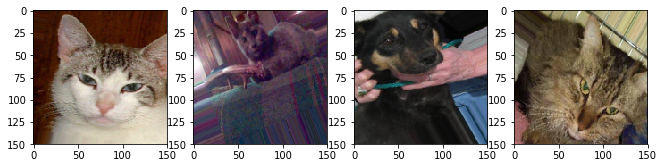

In [7]:
%matplotlib inline
rcParams['figure.figsize'] = 11, 8

fig, ax = plt.subplots(1,4)
for data_batch, labels_batch in train_generator:
    ax[0].imshow(data_batch[0])
    ax[1].imshow(data_batch[1])
    ax[2].imshow(data_batch[2])
    ax[3].imshow(data_batch[3])
    break

### Base Convolutional Mode

In [8]:
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False, 
    input_shape = (150, 150, 3)
)
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Create Model

In [15]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(config['dense_layer_size'], activation='relu'))
#model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


### Freeze Convolutional Layer

In [17]:
print('This is the number of trainable weights before freezing the conv base:', 
     len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4


In [18]:
conv_base.trainable = False

In [19]:
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


### Compile Model

In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [21]:
class TensorBoardWrapper(TensorBoard):
    '''Sets the self.validation_data property for use with TensorBoard callback.'''

    def __init__(self, batch_gen, nb_steps, b_size, **kwargs):
        super(TensorBoardWrapper, self).__init__(**kwargs)
        self.batch_gen = batch_gen # The generator.
        self.nb_steps = nb_steps   # Number of times to call next() on the generator.
        #self.batch_size = b_size

    def on_epoch_end(self, epoch, logs):
        # Fill in the `validation_data` property. Obviously this is specific to how your generator works.
        # Below is an example that yields images and classification tags.
        # After it's filled in, the regular on_epoch_end method has access to the validation_data.
        imgs, tags = None, None
        for s in range(self.nb_steps):
            ib, tb = next(self.batch_gen)
            if imgs is None and tags is None:
                imgs = np.zeros(((self.nb_steps * self.batch_size,) + ib.shape[1:]), dtype=np.float32)
                tags = np.zeros(((self.nb_steps * self.batch_size,) + tb.shape[1:]), dtype=np.uint8)
            imgs[s * ib.shape[0]:(s + 1) * ib.shape[0]] = ib
            tags[s * tb.shape[0]:(s + 1) * tb.shape[0]] = tb
        
        self.validation_data = [imgs, tags, np.ones(imgs.shape[0])]
              
        return super(TensorBoardWrapper, self).on_epoch_end(epoch, logs)

In [22]:
tbw = TensorBoardWrapper(validation_generator, nb_steps=50 // 20, b_size=20, log_dir='./log',
                       histogram_freq=1,
                       write_graph=False, write_grads=True)

In [24]:
history = model.fit_generator(train_generator, epochs=config['epochs'], steps_per_epoch=100, validation_data=validation_generator, validation_steps=50, callbacks=[])

Epoch 1/30
100/100 [==============================] - 39s 386ms/step - loss: 0.4873 - acc: 0.7705 - val_loss: 0.2979 - val_acc: 0.8770
Epoch 2/30
100/100 [==============================] - 21s 212ms/step - loss: 0.4008 - acc: 0.8175 - val_loss: 0.2777 - val_acc: 0.8710
Epoch 3/30
100/100 [==============================] - 21s 213ms/step - loss: 0.3558 - acc: 0.8390 - val_loss: 0.2929 - val_acc: 0.8760
Epoch 4/30
100/100 [==============================] - 21s 212ms/step - loss: 0.3596 - acc: 0.8425 - val_loss: 0.2640 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 21s 213ms/step - loss: 0.3293 - acc: 0.8555 - val_loss: 0.3084 - val_acc: 0.8720
Epoch 6/30
100/100 [==============================] - 21s 212ms/step - loss: 0.3313 - acc: 0.8490 - val_loss: 0.2568 - val_acc: 0.8920
Epoch 7/30
100/100 [==============================] - 21s 212ms/step - loss: 0.3285 - acc: 0.8560 - val_loss: 0.2895 - val_acc: 0.8690
Epoch 8/30
100/100 [==============================] - 2

### Save model

In [25]:
model.save('candd05.h5')

### Loss & Accuracy

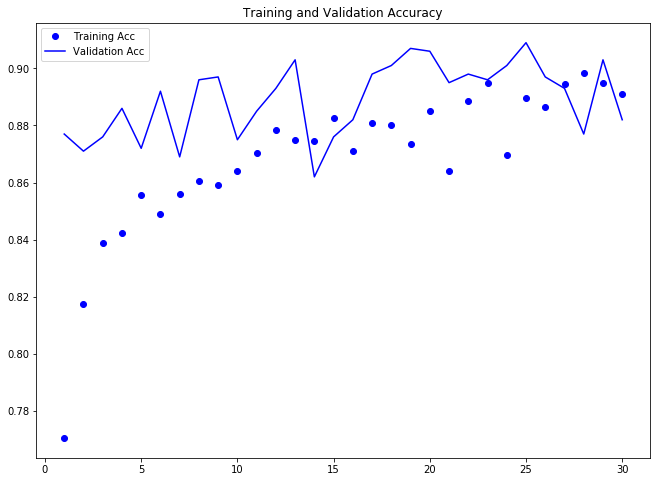

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


### Training and Validation loss

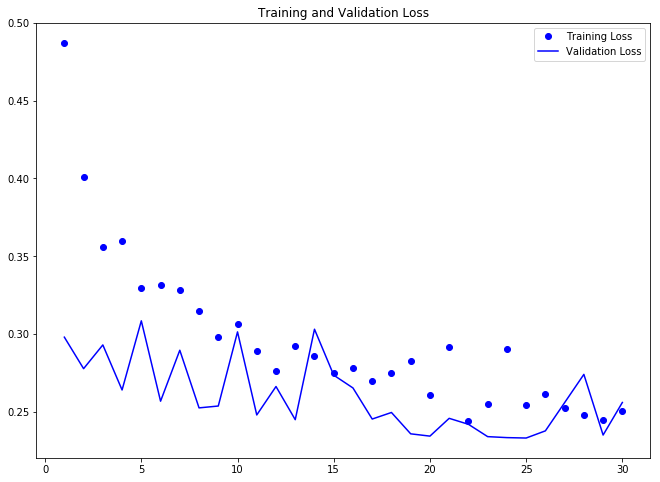

In [27]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()